# 4M24 - MCMC Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cw_functions import *

## Intro generate true u and simulate v

In [2]:
# GENERATE DATA
seed = 0
np.random.seed(seed)

### Inference grid defining {ui}i=1,Nx*Ny
Nx = 16 # equivalent of D
Ny = 16
N = Nx * Ny     # Total number of coordinates
points = [(x, y) for y in np.arange(Nx) for x in np.arange(Ny)]                # Indexes for the inference grid
coords = [(x, y) for y in np.linspace(0,1,Ny) for x in np.linspace(0,1,Nx)]    # Coordinates for the inference grid
xi, yi = np.array([c[0] for c in points]), np.array([c[1] for c in points])    # Get x, y index lists
x, y = np.array([c[0] for c in coords]), np.array([c[1] for c in coords])      # Get x, y coordinate lists

### Data grid defining {vi}i=1,Dx*Dy subsampled from inference grid
subsample_factor = 4
idx = subsample(N, subsample_factor)
M = len(idx)                                                                   # Total number of data points

### Generate K, the covariance of the Gaussian process, and sample from N(0,K) using a stable Cholesky decomposition
l = 0.3
C = GaussianKernel(coords, l)
z = np.random.randn(N)
Cc = np.linalg.cholesky(C + 1e-6 * np.eye(N))
u = Cc @ z

### Observation model: v = G(u) + e,   e~N(0,I)
G = get_G(N, idx)
v = G @ u + np.random.randn(M)

## a): plot surfaces

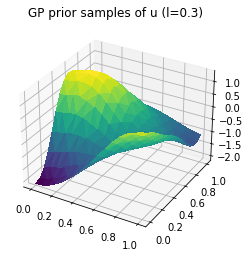

In [3]:
plot_3D(u, x, y, title="GP prior samples of u (l={})".format(l))  # Plot original u surface

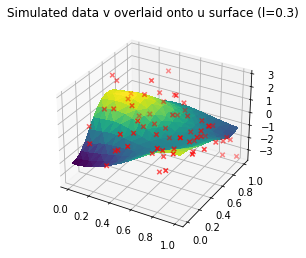

In [4]:
plot_result(u, v, x, y, x[idx], y[idx], title="Simulated data v overlaid onto u surface (l={})".format(l))               # Plot original u with data v

## b) MCMC

In [5]:
### Set MCMC parameters
n = 1000
beta = 0.2

### Sample from prior for MCMC initialisation
z = np.random.randn(N)
u0 = Cc @ z

### GRW-MH

In [6]:
grw_X, grw_accept = grw(log_target=log_continuous_target, u0=u0, data=v, K=C, G=G, n_iters=n, beta=beta)
print("\n acceptance ratio: {}".format(grw_accept))

100%|██████████| 1000/1000 [00:35<00:00, 28.21it/s]
 acceptance ratio: 0.515



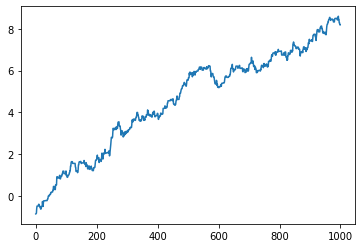

In [7]:
plt.plot(np.mean(grw_X, axis=1))
plt.show()

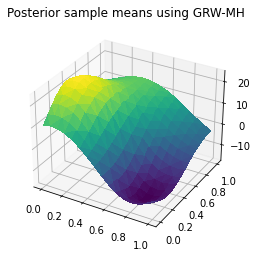

In [8]:
u_estimate = np.mean(grw_X, axis=0)
plot_3D(u_estimate, x, y, title="Posterior sample means using GRW-MH")

### pCN

In [9]:
pcn_X, pcn_accept = pcn(log_likelihood=log_continuous_likelihood_fast, u0=u0, y=v, K=C, G=G, n_iters=n, beta=beta)
print("\n acceptance ratio: {}".format(pcn_accept))

100%|██████████| 1000/1000 [00:00<00:00, 2726.38it/s]
 acceptance ratio: 0.428



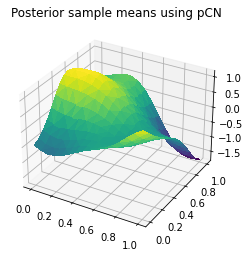

In [10]:
u_estimate = np.mean(pcn_X, axis=0)
plot_3D(u_estimate, x, y, title="Posterior sample means using pCN")

## c) Probit classification 

In [11]:
t = probit(v)       # Probit transform of data

probit_samples, probit_accept = pcn(log_likelihood=log_probit_likelihood, u0=u0, y=t, K=C, G=G, n_iters=n, beta=beta)
print("\n acceptance ratio: {}".format(probit_accept))

100%|██████████| 1000/1000 [00:00<00:00, 1060.69it/s]
 acceptance ratio: 0.553



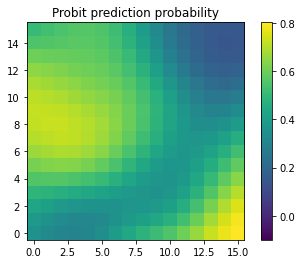

In [12]:
t_star_probs = predict_t(probit_samples)
plot_2D(t_star_probs, xi, yi, title='Probit prediction probability')

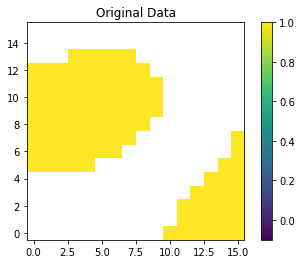

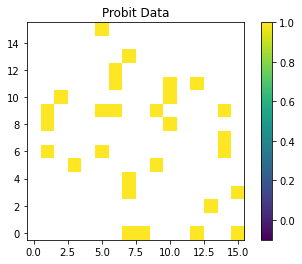

In [13]:
### Plotting examples
plot_2D(probit(u), xi, yi, title='Original Data')     # Plot true class assignments
plot_2D(t, xi[idx], yi[idx], title='Probit Data')     # Plot data

## d) Hard assignment

In [14]:
t_hard = [1 if t_star >= 0.5 else -1 for t_star in t_star_probs]
t_true = probit(u)
abs_error = np.abs((t_hard - t_true) / 2)
mean_abs_error = np.mean(abs_error)
print(mean_abs_error)

0.13671875
